# TWITTER HATE SPEECH CLASSIFICATION

## Importing necessary libraries

In [1]:
import pandas as pd
import nltk
import spacy
import re

# importing text preprocessing functions
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from string import punctuation

## Loading Data

In [2]:
data = pd.read_csv('TwitterHate.csv', delimiter= ',',
                   engine = 'python', encoding = 'utf-8-sig')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [4]:
# column 'id' is unnecessary, get rid of it as we have similar index column 
# lets first take backup of data
databkp = data.copy()

In [5]:
data.drop('id', axis = 1, inplace = True)
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


## 1. Text cleanup

### 1. Normalizing case of tweets

In [6]:
# unicode data
def unicoding(text):
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [7]:
data['tweet'] = data['tweet'].apply(unicoding)

In [8]:
# 1. normalize casing
data['cleantweet'] = [tweet.lower() for tweet in data['tweet']]

### 2. Removing user handles

In [9]:
# 2. removing user handles
pattern = re.compile(r'@\w*')
data['cleantweet'] = [re.sub(pattern,'',tweet) for tweet in data['tweet']]
data['cleantweet'][:5]

0      when a father is dysfunctional and is so sel...
1      thanks for #lyft credit i can't use cause th...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: cleantweet, dtype: object

### 3. Removing urls

In [10]:
# 3. removing urls
# Types of urls 
#urls = [re.findall(r'https?://\w+',tweet) for tweet in data['tweet']]
#print(urls)

In [11]:
url_removed = [re.sub(r'http\S+','', tweet) for tweet in data['cleantweet']]
print(url_removed)

['  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run', "  thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked", '  bihday your majesty', '#model   i love u take with u all the time in ur!!!   ', ' factsguide: society now    #motivation', '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  ', '  camping tomorrow        dannya', "the next school year is the year for exams. can't think about that  #school #exams   #hate #imagine #actorslife #revolutionschool #girl", 'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  a ', "   welcome here !  i'm   it's so #gr8 ! ", ' a #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex', 'we are so selfish. #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish #heabreakin

#### Check whether removing urls makes any difference

In [12]:
lengthbefore = [len(tweet) for tweet in data['cleantweet']]
print(lengthbefore)

[97, 112, 21, 54, 39, 116, 32, 135, 85, 40, 109, 133, 51, 69, 101, 52, 58, 22, 69, 58, 127, 70, 100, 37, 65, 79, 102, 72, 22, 135, 125, 67, 117, 106, 104, 109, 46, 121, 95, 52, 97, 100, 62, 71, 95, 47, 54, 46, 29, 53, 76, 76, 66, 34, 79, 68, 34, 85, 86, 56, 104, 105, 62, 33, 124, 49, 73, 45, 106, 77, 61, 68, 110, 111, 29, 73, 40, 75, 95, 111, 43, 99, 77, 136, 88, 36, 64, 132, 100, 35, 87, 35, 110, 128, 107, 109, 54, 46, 64, 64, 43, 131, 60, 90, 25, 56, 133, 64, 76, 51, 79, 122, 74, 68, 52, 83, 78, 54, 70, 66, 68, 109, 62, 61, 47, 46, 75, 102, 88, 107, 94, 104, 94, 75, 117, 120, 52, 107, 73, 111, 71, 83, 76, 112, 56, 90, 36, 96, 113, 131, 82, 110, 92, 80, 63, 108, 109, 103, 83, 122, 41, 48, 54, 41, 45, 87, 86, 83, 109, 48, 98, 130, 37, 28, 120, 129, 105, 83, 65, 92, 95, 125, 71, 89, 76, 100, 77, 93, 140, 49, 82, 92, 63, 92, 109, 103, 107, 109, 41, 100, 87, 63, 39, 48, 55, 42, 32, 89, 92, 120, 104, 106, 73, 25, 48, 60, 123, 67, 54, 122, 72, 134, 47, 96, 53, 116, 109, 33, 56, 63, 49, 128,

In [13]:
lengthafter = [len(tweet) for tweet in url_removed]
print(lengthafter)

[97, 112, 21, 54, 39, 116, 32, 135, 85, 40, 109, 133, 51, 69, 101, 52, 58, 22, 69, 58, 127, 70, 100, 37, 65, 79, 102, 72, 22, 135, 125, 67, 117, 106, 104, 109, 46, 121, 95, 52, 97, 100, 62, 71, 95, 47, 54, 46, 29, 53, 76, 76, 66, 34, 79, 68, 34, 85, 86, 56, 104, 105, 62, 33, 124, 49, 73, 45, 106, 77, 61, 68, 110, 111, 29, 73, 40, 75, 95, 111, 43, 99, 77, 136, 88, 36, 64, 132, 100, 35, 87, 35, 110, 128, 107, 109, 54, 46, 64, 64, 43, 131, 60, 90, 25, 56, 133, 64, 76, 51, 79, 122, 74, 68, 52, 83, 78, 54, 70, 66, 68, 109, 62, 61, 47, 46, 75, 102, 88, 107, 94, 104, 94, 75, 117, 120, 52, 107, 73, 111, 71, 83, 76, 112, 56, 90, 36, 96, 113, 131, 82, 110, 92, 80, 63, 108, 109, 103, 83, 122, 41, 48, 54, 41, 45, 87, 86, 83, 109, 48, 98, 130, 37, 28, 120, 129, 105, 83, 65, 92, 95, 125, 71, 89, 76, 100, 77, 93, 140, 49, 82, 92, 63, 92, 109, 103, 107, 109, 41, 100, 87, 63, 39, 48, 55, 42, 32, 89, 92, 120, 104, 106, 73, 25, 48, 60, 123, 67, 54, 122, 72, 134, 47, 96, 53, 116, 109, 33, 56, 63, 49, 128,

In [14]:
import numpy as np
np.sum(lengthbefore) - np.sum(lengthafter)
# if there would have difference, this subtraction value would not be zero

0

### 4. Tweet tokenization

In [15]:
from nltk import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case = True)

In [16]:
data['cleantweet'] = data['cleantweet'].apply(tokenizer.tokenize)
data.head()

,label,tweet,cleantweet
0,0,@user when a father is dysfunctional and is s...,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,@user @user thanks for #lyft credit i can't us...,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,bihday your majesty,"[bihday, your, majesty]"
3,0,#model i love u take with u all the time in ...,"[#model, i, love, u, take, with, u, all, the, ..."
4,0,factsguide: society now #motivation,"[factsguide, :, society, now, #motivation]"


### 5. Removing stopwords

In [17]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Adi
[nltk_data]     Kurhade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
# 6. Remove redundant words
# we need to remove redundant words as well, we will add them to stopwords to reduce additional step
stop_words.extend(['amp','rt','u',"can't",'ur'])
print(stop_words[-5:])

['amp', 'rt', 'u', "can't", 'ur']


In [20]:
def RemoveStopwords(tweet):
  stopwords_removed = [word for word in tweet if word not in stop_words]
  return stopwords_removed

In [21]:
data['cleantweet'] = data['cleantweet'].apply(RemoveStopwords)
print(data['cleantweet'][:10])

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, use, cause, offer, whe...
2                                    [bihday, majesty]
3                  [#model, love, take, time, !, !, !]
4                [factsguide, :, society, #motivation]
5    [[, 2/2, ], huge, fan, fare, big, talking, lea...
6                          [camping, tomorrow, dannya]
7    [next, school, year, year, exams, ., think, #s...
8    [!, !, !, love, land, !, !, !, #allin, #cavs, ...
9                           [welcome, !, i'm, #gr8, !]
Name: cleantweet, dtype: object


### 7. Remove ‘#’ symbols from the tweet while retaining the term.

In [22]:
def remove_hash(tweet):
  '''
  function to remove hashtags from text string
  args:
  tweet : text string of tweet
  uses regular expression library
  returns tweet without hashtags
  '''
  pattern = re.compile(r'#')
  text = " ".join(tweet)         # re.sub() expects string as argument 
  hash_removed = re.sub(pattern,'',text)
  return tokenizer.tokenize(hash_removed)

In [23]:
data['cleantweet'] = data['cleantweet'].apply(remove_hash)
print(data['cleantweet'][:10])

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, lyft, credit, use, cause, offer, whee...
2                                    [bihday, majesty]
3                   [model, love, take, time, !, !, !]
4                 [factsguide, :, society, motivation]
5    [[, 2/2, ], huge, fan, fare, big, talking, lea...
6                          [camping, tomorrow, dannya]
7    [next, school, year, year, exams, ., think, sc...
8    [!, !, !, love, land, !, !, !, allin, cavs, ch...
9                            [welcome, !, i'm, gr8, !]
Name: cleantweet, dtype: object


## 2. Extra cleanup

In [24]:
def extra_cleanup(tweet):
  '''
  function to remove shorter words with length of 1 (i.e. one letter words), digits and punctuation
  args 
  tweet = string of text
  return:
  tweet without shortwords, digits and punctuation
  '''
  shortword_removed = [word for word in tweet if len(word)>1] # removing words of length 1
  digit_removed = [word for word in shortword_removed if not word.isdigit()]
  punct_removed = [word for word in digit_removed if word not in punctuation]
  return punct_removed

In [25]:
data['cleantweet'] = data['cleantweet'].apply(extra_cleanup)
print(data['cleantweet'][:10])

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, lyft, credit, use, cause, offer, whee...
2                                    [bihday, majesty]
3                            [model, love, take, time]
4                    [factsguide, society, motivation]
5    [2/2, huge, fan, fare, big, talking, leave, ch...
6                          [camping, tomorrow, dannya]
7    [next, school, year, year, exams, think, schoo...
8    [love, land, allin, cavs, champions, cleveland...
9                                  [welcome, i'm, gr8]
Name: cleantweet, dtype: object


In [26]:
def remove_dots(tweet):         # remove '...' from tweets
  text = " ".join(tweet)
  pattern = re.compile(r'\.+')
  dot_removed = re.sub(pattern,'', text)
  return tokenizer.tokenize(dot_removed)

In [27]:
data['cleantweet']= data['cleantweet'].apply(remove_dots)
print(data['cleantweet'][15])

['ouch', 'junior', 'angry', 'got', 'junior', 'yugyoem', 'omg']


## 5. Check out the top terms in the tweets:

### 1. large list of all tokenized terms

In [28]:
tweetlist = list(data['cleantweet'])
tweetlist = sum(tweetlist, []) 
print(tweetlist[:30])

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run', 'thanks', 'lyft', 'credit', 'use', 'cause', 'offer', 'wheelchair', 'vans', 'pdx', 'disapointed', 'getthanked', 'bihday', 'majesty', 'model', 'love', 'take', 'time', 'factsguide', 'society', 'motivation', '2/2', 'huge', 'fan']


### 2. finding top 10 most common terms

In [29]:
from collections import Counter
mostcommon = Counter(tweetlist).most_common(10)

In [30]:
print(mostcommon)

[('love', 2760), ('day', 2300), ('happy', 1685), ('time', 1138), ('life', 1118), ('like', 1110), ('today', 1016), ("i'm", 1015), ('new', 994), ('thankful', 947)]


### 3. lets check data balance

In [31]:
data['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

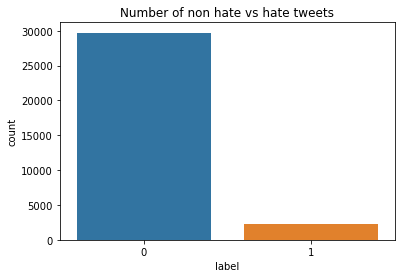

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x =data['label'])
plt.title('Number of non hate vs hate tweets')
plt.show()

## 6. Data formatting for predictive modeling:

### 1. joining all tokens again to form strings

In [33]:
data['cleantweet'] = data['cleantweet'].apply(lambda x : " ".join(x))

In [34]:
print(data['cleantweet'][:10])

0    father dysfunctional selfish drags kids dysfun...
1    thanks lyft credit use cause offer wheelchair ...
2                                       bihday majesty
3                                 model love take time
4                        factsguide society motivation
5    2/2 huge fan fare big talking leave chaos pay ...
6                              camping tomorrow dannya
7    next school year year exams think school exams...
8    love land allin cavs champions cleveland cleve...
9                                      welcome i'm gr8
Name: cleantweet, dtype: object


### 2. assign X and y

In [35]:
X = data['cleantweet']
y = data['label']

### 3. performing train test split

In [36]:
from sklearn.model_selection import train_test_split
# we use stratify to have equal number of hate tweets in train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) 
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(25569,) (6393,) (25569,) (6393,)


## 7. Vectorization using TF-IDF vectorizer

In [37]:
# importing tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# instantiate vectorizer for maximum 5000 terms in vocabulary
vectorizer = TfidfVectorizer(max_features = 5000)

In [38]:
# fit and apply on train set 
xtrain = vectorizer.fit_transform(xtrain)
# apply on test set
xtest = vectorizer.transform(xtest)

In [39]:
# check
print(xtrain.shape, xtest.shape)

(25569, 5000) (6393, 5000)


##  8. Model building: Ordinary Logistic Regression

In [40]:
# importing logistic regression algoritm from sklearn
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
# fit on train data
logreg.fit(xtrain, ytrain)

LogisticRegression()

In [41]:
# predictions on train and test data
train_pred = logreg.predict(xtrain)
test_pred = logreg.predict(xtest)

print(train_pred.shape, test_pred.shape)

(25569,) (6393,)


## 9. Model Evaluation

In [42]:
# import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [43]:
# acccuracy score
print('accuracy score on train set:', accuracy_score(ytrain, train_pred))
print('accuracy score on test set:', accuracy_score(ytest, test_pred))

accuracy score on train set: 0.9556103093589894
accuracy score on test set: 0.9518223056468011


* As our data is highly imbalanced, accuracy score is never good metric to test model performance.
* We will check f1 score and recall too.

In [44]:
# classification report on train set
print('classification report on train set:')
print(classification_report(ytrain, train_pred))

classification report on train set:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     23775
           1       0.95      0.39      0.55      1794

    accuracy                           0.96     25569
   macro avg       0.95      0.69      0.76     25569
weighted avg       0.96      0.96      0.95     25569



In [45]:
# classification report on test set
print('classification report on test set:')
print(classification_report(ytest, test_pred))

classification report on test set:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5945
           1       0.91      0.35      0.50       448

    accuracy                           0.95      6393
   macro avg       0.93      0.67      0.74      6393
weighted avg       0.95      0.95      0.94      6393



## 10. Weighted Logistic Regression

* f1-score for 'label 1' i.e. 'hate speech' is lower for both train and test set
* Our model focussing on 'label 0' more as expected due to data imbalance

In [46]:
# data imbalance 
data.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [47]:
# check for hate speech to non_hate speech ratio
ratio = 29720/2241
print(int(ratio))

13


* For 1 'label 1' there are 13 'label 0's ' approx., we will adjust class weight accordingly (class ratio 1:13)

In [48]:
# defining weights with ratio inverse of the class distribution
weights = {0:1.0, 1:13.0}

# Instantiate Logistic Regression model 
wlogreg = LogisticRegression(solver= 'lbfgs', class_weight= weights)

# fit on train data
wlogreg.fit(xtrain, ytrain)
w_train_pred = wlogreg.predict(xtrain)
w_test_pred = wlogreg.predict(xtest)

In [49]:
print('classification report on train set with weighted logistic regression :')
print(classification_report(ytrain, w_train_pred))

classification report on train set with weighted logistic regression :
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     23775
           1       0.60      0.98      0.74      1794

    accuracy                           0.95     25569
   macro avg       0.80      0.96      0.86     25569
weighted avg       0.97      0.95      0.96     25569



In [50]:
print('classification report on test set with weighted logistic regression :')
print(classification_report(ytest, w_test_pred))

classification report on test set with weighted logistic regression :
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5945
           1       0.49      0.77      0.60       448

    accuracy                           0.93      6393
   macro avg       0.74      0.86      0.78      6393
weighted avg       0.95      0.93      0.93      6393



## 12. Regularization and Hyperparameter tuning

In [51]:
# Importing libraries for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [52]:
# Define parameter grid
import numpy as np
param = {'penalty':['l1','l2'],
         'solver' :['saga', 'lbfgs', 'liblinear'],
         'C':[10,15,20,25,30]}

print(param)

{'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs', 'liblinear'], 'C': [10, 15, 20, 25, 30]}


### logistic regression with balanced weights

In [53]:
# instantiate model
bal_wt = {0:1.0, 1:1.0}
bal_logreg = LogisticRegression(class_weight= bal_wt, max_iter = 200)

## 13. Finding best parameters using grid search

In [63]:
# define grid search
folds = StratifiedKFold(n_splits=4)
grid_search = GridSearchCV(estimator=bal_logreg, param_grid=param, scoring= 'recall', cv=folds, n_jobs=-1)

In [64]:
results = grid_search.fit(xtrain, ytrain)
print(results.best_params_)

C:\anacondafolder\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.60535689        nan 0.607031   0.52453493 0.52397814 0.52397814
 0.60758282        nan 0.6148261  0.54794136 0.54794136 0.54794136
 0.61650145        nan 0.62040646 0.55853037 0.55853037 0.55853037
 0.61538662        nan 0.62375592 0.56689096 0.56744899 0.56689096
 0.61817307        nan 0.62765719 0.57246137 0.57301817 0.57301817]
  warnings.warn(


{'C': 30, 'penalty': 'l1', 'solver': 'liblinear'}


In [65]:
# instantiating new model with best parameters
best_model = LogisticRegression(class_weight = bal_wt,C=30, penalty = 'l1', solver='liblinear')

In [66]:
# fit and train
best_model.fit(xtrain,ytrain)
best_train_pred = best_model.predict(xtrain)
best_test_pred = best_model.predict(xtest)

In [67]:
print('classification report on training set with best model and balanced weights : \n',
      '\n',
     classification_report(ytrain,best_train_pred))

classification report on training set with best model and balanced weights : 
 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.98      0.95      0.97      1794

    accuracy                           1.00     25569
   macro avg       0.99      0.97      0.98     25569
weighted avg       1.00      1.00      1.00     25569



In [68]:
print('classification report on test set with best model and balanced weights : \n',
      '\n',
     classification_report(ytest,best_test_pred))

classification report on test set with best model and balanced weights : 
 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.64      0.66      0.65       448

    accuracy                           0.95      6393
   macro avg       0.80      0.82      0.81      6393
weighted avg       0.95      0.95      0.95      6393



* model with best parameters is not performing well with test data
* lets check performance of model with best parameters but with weights we defined earlier in weighted logistic regression

## 15. Predict and evaluate using best estimator

In [69]:
# weights = {0:1.0, 1:13.0}

w_best_model = LogisticRegression(class_weight = weights,C=30, penalty = 'l1', solver='liblinear')
w_best_model.fit(xtrain,ytrain)

LogisticRegression(C=30, class_weight={0: 1.0, 1: 13.0}, penalty='l1',
                   solver='liblinear')

In [71]:
w_best_train_pred = w_best_model.predict(xtrain)
w_best_test_pred = w_best_model.predict(xtest)

In [72]:
print('classification report on training set with best model and weights according to class imbalance: \n',
      '\n',
     classification_report(ytrain,w_best_train_pred))

classification report on training set with best model and weights according to class imbalance: 
 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     23775
           1       0.90      1.00      0.94      1794

    accuracy                           0.99     25569
   macro avg       0.95      0.99      0.97     25569
weighted avg       0.99      0.99      0.99     25569



In [74]:
print('classification report on test set with best model and weights according to class imbalance: \n',
      '\n',
     classification_report(ytest,w_best_test_pred))

classification report on test set with best model and weights according to class imbalance: 
 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5945
           1       0.48      0.73      0.58       448

    accuracy                           0.93      6393
   macro avg       0.73      0.84      0.77      6393
weighted avg       0.94      0.93      0.93      6393



In [77]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion matrix on test set : \n',
     confusion_matrix(ytest,w_best_test_pred, labels=[0,1]))

Confusion matrix on test set : 
 [[5593  352]
 [ 119  329]]


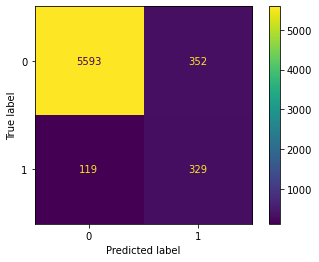

In [80]:
# display confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(ytest,w_best_test_pred, labels=[0,1])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
display.plot()
plt.show()

## Conclusion

**Recall on test set using**

* 1. Logistic Regression with ***default parameters = 0.35***
* 2. Logistic Regression with ***weights proportional to data imbalance = 0.77***
* 3. Logistic Regression with ***best parameters from gridsearch and balanced weights = 0.66***
* 4. Logistic Regression with ***best parameters from gridsearch and weights proportional to data imbalance = 0.73***